# Spectral Augmentation

From [Data augmentation and loss normalization for deep noise suppression](https://arxiv.org/abs/2008.06412)  
Originated from [A Hybrid DSP/Deep Learning Approach to Real-Time Full-Band Speech Enhancement](https://ieeexplore.ieee.org/abstract/document/8547084)   
  
 
Using Biquiad Filter to spectral augmentation  
![image](augmentation.png)

$$ H(z) = \frac{1 + r_1z^{-1} + r_2z^{-2}}{1 + r_3z^{-1} + r_4z^{-2}}  \tag{4} $$ 

$$ r_i \in [-\frac{3}{8}, \frac{3}{8}] , \text{uniformly distributed}$$ 

In [1]:
import librosa
import numpy as np
import IPython.display as ipd
# ipd.Audio('audio/conga_groove.wav') # load a local WAV file
# ipd.Audio(x, rate=sr) # load a NumPy array
import matplotlib
import matplotlib.pylab as plt
from matplotlib import cm

In [2]:
def spectrogram(x,STFT=False) : 
    print(np.shape(x))
    eps = 1e-13
    if STFT : 
        pass
    else :
        x = librosa.stft(x,window='hann', n_fft=1024, hop_length=256 , win_length=None ,center=True)
    # dB scale
    tmp =(np.abs(x[:,:]))
    tmp = np.clip(tmp,a_min=eps,a_max=None)
    tmp = 20*np.log10(tmp)
    tmp = tmp[::-1,:]

    im = plt.imshow(tmp, cmap=cm.jet, aspect='auto')
    plt.colorbar(im)
    plt.clim(-80,20)
    plt.show()

In [3]:
sr = 16000

In [4]:
path_clean = '../data/wav/clean.wav'
path_noise = '../data/wav/noise.wav'

In [5]:
clean,_ = librosa.load(path_clean,sr=sr)
noise,_ = librosa.load(path_noise,sr=sr)

$$ y(n) = x(n)+ r_1 x(n-1) + r_2 x(n-2) - r_3 y(n-1) - r_4 y(n-2) $$ 

In [6]:
def biquad_filter(x,STFT=False):
    
    r = (np.random.rand(4)-0.5)*(3/8)
   # r = (np.random.rand(4)-0.5)*(1)
    
    #r = [-3/8, 0, -0, 3/8]
    
    print(np.shape(x))
    # STFT domain
    if STFT : 
        r = r *(1+0*1j)
        print('r : ' + str(r))
        
        n_fft = np.shape(x)[0]
        length = np.shape(x)[1]
        
        y = np.zeros((n_fft,length),dtype=np.complex64)
        
        y[0] = x[0]
        y[1] = x[1] + r[0]*x[0] - r[2]*y[0]
        
        for i in range(2,length):
            y[:,i] = x[:,i] + r[0]*x[:,i-1] + r[1]*x[:,i-2] - r[2]*y[:,i-1] - r[3]*y[:,i-2]
            
    # wav domain
    else :

        y = np.zeros(np.shape(x))

        print('r : ' + str(r))

        y[0] = x[0]
        y[1] = x[1] + r[0]*x[0] - r[2]*y[0]

        for i in range(2,len(x)):
            y[i] = x[i] + r[0]*x[i-1] + r[1]*x[i-2] - r[2]*y[i-1] - r[3]*y[i-2]
    
    return y
    

## clean

(99810,)


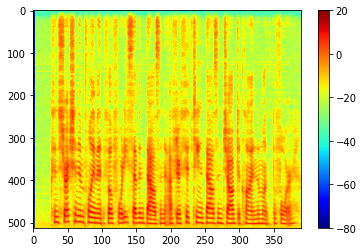

(99810,)
r : [ 0.01598747  0.01945369 -0.08958213  0.1195251 ]


## aug_clean

(99810,)


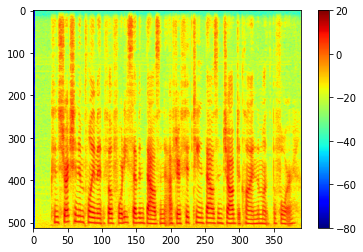

np.sum(np.abs(clean-aug_clean)) : 142.38520068165346


In [7]:
ipd.display(ipd.Markdown('## clean'))
#ipd.display(ipd.Audio(clean, rate=sr))

spectrogram(clean)
aug_clean = biquad_filter(clean)


ipd.display(ipd.Markdown('## aug_clean'))
#ipd.display(ipd.Audio(aug_clean, rate=sr))
spectrogram(aug_clean)
print('np.sum(np.abs(clean-aug_clean)) : ' + str(np.sum(np.abs(clean-aug_clean))))

## FREQ domain에서 해야하지 않나?

In [8]:
spec_clean = librosa.stft(clean,window='hann', n_fft=1024, hop_length=256 , win_length=None ,center=True)
print(np.shape(spec_clean))

(513, 390)


## clean

(513, 390)


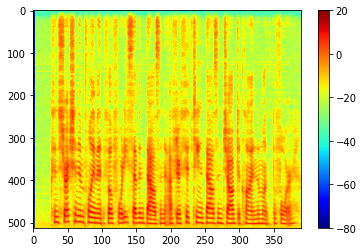

(513, 390)
r : [ 0.06244641+0.j -0.15436598+0.j  0.02899808+0.j -0.15198268+0.j]


## aug_clean

(513, 390)


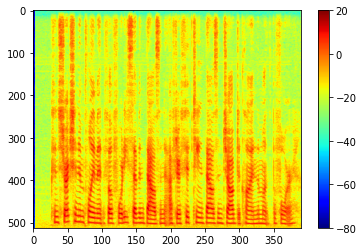

np.sum(np.abs(clean-aug_clean)) : 1814.4408


In [9]:
ipd.display(ipd.Markdown('## clean'))
ipd.display(ipd.Audio(clean, rate=sr))

spectrogram(spec_clean,STFT=True)
aug_spec_clean = biquad_filter(spec_clean,STFT=True)

ipd.display(ipd.Markdown('## aug_clean'))
aug_clean = librosa.istft(aug_spec_clean,window='hann', hop_length=256 , win_length=None ,center=True)
ipd.display(ipd.Audio(aug_clean, rate=sr))
spectrogram(aug_spec_clean,STFT=True)
print('np.sum(np.abs(clean-aug_clean)) : ' + str(np.sum(np.abs(spec_clean-aug_spec_clean))))

In [10]:
np.shape(spec_clean)[1]

390

소리가 떠있는 느낌인데. 이걸 반향이라고 할 수 있나? 반향처럼 보이지는 않는데 그렇게 들리네. RT60이 매우 낮게 변형이 된건가?